In [15]:
import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession

# from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("ML_Model").getOrCreate()
# spark.conf.set("spark.executor.memory", "8g")
# spark.conf.set("spark.executor.cores", "4")
# spark.conf.set("spark.driver.cores", "4")
# conf = SparkConf().set("spark.jars", "/Users/sz904/Downloads/postgresql-42.2.18.jar")
# sc = SparkContext( conf=conf)



In [16]:
col_names = [
    'tcp_flags',
    'tcp_time_delta',
    'tcp_len',
    'mqtt_conack_flags',
    'mqtt_conack_flags_reserved',
    'mqtt_conack_flags_sp',
    'mqtt_conack_val',
    'mqtt_conflag_cleansess',
    'mqtt_conflag_passwd',
    'mqtt_conflag_qos',
    'mqtt_conflag_reserved',
    'mqtt_conflag_retain',
    'mqtt_conflag_uname',
    'mqtt_conflag_willflag',
    'mqtt_conflags',
    'mqtt_dupflag',
    'mqtt_hdrflags',
    'mqtt_kalive',
    'mqtt_len',
    'mqtt_msg',
    'mqtt_msgid',
    'mqtt_msgtype',
    'mqtt_proto_len',
    'mqtt_protoname',
    'mqtt_qos',
    'mqtt_retain',
    'mqtt_sub_qos',
    'mqtt_suback_qos',
    'mqtt_ver',
    'mqtt_willmsg',
    'mqtt_willmsg_len',
    'mqtt_willtopic',
    'mqtt_willtopic_len',
    'target',
    'dataset',
    'tcp_flags_decimal',
    'mqtt_conflags_decimal',
    'mqtt_hdrflags_decimal'
]

nominal_cols = ["mqtt_msg"]

corelated_cols_to_remove = ["mqtt_conack_flags",
                     "mqtt_conack_flags_reserved",
                     "mqtt_conack_flags_sp", 
                     "mqtt_conflag_qos", 
                     "mqtt_conflag_reserved", 
                     "mqtt_conflag_retain", 
                     "mqtt_conflag_willflag", 
                     "mqtt_willtopic", 
                     "mqtt_willtopic_len", 
                     "mqtt_sub_qos", 
                     "mqtt_suback_qos", 
                     "mqtt_willmsg",
                     "mqtt_willmsg_len"]



binary_cols = ["mqtt_conack_val", 
                  "mqtt_conflag_cleansess", 
                  "mqtt_conflag_passwd", 
                  "mqtt_conflag_uname", 
                  "mqtt_dupflag", 
                  "mqtt_proto_len", 
                  "mqtt_protoname", 
                  "mqtt_qos", 
                  "mqtt_retain", 
                  "mqtt_ver"]


continuous_cols = ["tcp_flags_decimal",
                     'tcp_time_delta',
                     'tcp_len',
                     'mqtt_kalive',
                     'mqtt_len',
                     'mqtt_msgid',
                     'mqtt_msgtype',
                     'mqtt_conflags_decimal', 
                     "mqtt_hdrflags_decimal", ]

In [17]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import numpy as np
from matplotlib import pyplot as plt


class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        # label_to_binary = udf(lambda name: 0.0 if name == 'normal' else 1.0)
        # output_df = dataset.withColumn('outcome', label_to_binary(col('class'))).drop("class")  
        # output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        # output_df = output_df.drop('difficulty')
        # return output_df

        def converter(name):
            if name == 'legitimate':
                return 0
            elif name == 'dos':
                return 1      
            elif name == 'malformed':
                return 2     
            elif name == 'flood':
                return 3
            elif name == 'bruteforce':
                return 4   
            elif name == 'slowite':
                return 5  
            else:
                print("out of range")
                return None
            
        label_to_binary = udf(lambda name: converter(name))
        output_df = dataset.withColumn('label', label_to_binary(col('target')))
        output_df = output_df.drop("target")  
        output_df = output_df.withColumn('label', col('label').cast(DoubleType()))
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df



In [18]:
train_path = "/Users/sz904/Desktop/df_train_pandas.csv"
test_path = "/Users/sz904/Desktop/df_test_pandas.csv"
df_train_updated = spark.read.csv(train_path, header=True, inferSchema= True).toDF(*col_names)
df_test_updated = spark.read.csv(test_path, header=True, inferSchema= True).toDF(*col_names)
print(df_train_updated.count())
print(df_test_updated.count())


231646
99290


In [19]:
df_train_updated = df_train_updated.drop("tcp_flags")
df_train_updated = df_train_updated.drop("mqtt_conflags")
df_train_updated = df_train_updated.drop("mqtt_hdrflags")
df_train_updated = df_train_updated.drop("dataset")

df_test_updated = df_test_updated.drop("tcp_flags")
df_test_updated = df_test_updated.drop("mqtt_conflags")
df_test_updated = df_test_updated.drop("mqtt_hdrflags")
df_test_updated = df_test_updated.drop("dataset")


df_train_updated = df_train_updated.drop("mqtt_msg")
df_test_updated = df_test_updated.drop("mqtt_msg")

df_train_updated = df_train_updated.drop("mqtt_conack_flags")
df_test_updated = df_test_updated.drop("mqtt_conack_flags")

df_train_updated = df_train_updated.drop("mqtt_protoname")
df_test_updated = df_test_updated.drop("mqtt_protoname")

In [123]:
outcomeCreate = OutcomeCreater()
stage_vector_assembler = VectorAssembler(inputCols=[column for column in df_train_updated.columns if column != 'target'], outputCol="vectorized_features")
stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
len(stage_vector_assembler.getInputCols())


30

In [21]:
df_train = outcomeCreate.transform(df_train_updated)
df_train = stage_vector_assembler.transform(df_train)
scaler_model = stage_scaler.fit(df_train)
df_train = scaler_model.transform(df_train)
# df_train.printSchema()

In [22]:
df_test = outcomeCreate.transform(df_test_updated)
df_test = stage_vector_assembler.transform(df_test)
df_test = scaler_model.transform(df_test)
# df_test.printSchema()

In [23]:
dropper = ColumnDropper(
    [column for column in df_train.columns if column != 'label' and column != 'features']
)

df_train = dropper.transform(df_train)
df_test = dropper.transform(df_test)
df_train.printSchema()


root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



------------------Pyspark ML- Logistic Regression------------------------

In [100]:
# logistic model
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label')
#### default regparam 0, default maxIter = 100. 

In [101]:
lr_model = lr.fit(df_train)
lr_prediction_train = lr_model.transform(df_train)
lr_prediction_test = lr_model.transform(df_test)
lr_accuracy_train = evaluator.evaluate(lr_prediction_train)
lr_accuracy_test = evaluator.evaluate(lr_prediction_test)
print(f"Logistic Regression Train accuracy = {np.round(lr_accuracy_train*100,2)}%, test accuracy = {np.round(lr_accuracy_test*100,2)}%")


Logistic Regression Train accuracy = 80.45%, test accuracy = 80.08%


In [107]:
lr_model.getMaxIter()

100

In [103]:


# cross validation
lr_paramGrid = (ParamGridBuilder()
            .addGrid(lr.regParam, [0, 0.0001, 0.001])
            .addGrid(lr.maxIter, [ 120, 150, 200])
            .build())

evaluator = MulticlassClassificationEvaluator(
    predictionCol='prediction', 
    labelCol='label', 
    metricName='accuracy'
)

lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, 
                    evaluator=evaluator, numFolds=5)


In [104]:
lr_cv_model = lr_cv.fit(df_train)
res_train = lr_cv_model.transform(df_train)
res_test = lr_cv_model.transform(df_test)


In [112]:
print(lr_cv_model.getEstimatorParamMaps()[np.argmax(lr_cv_model.avgMetrics)])


{Param(parent='LogisticRegression_cd7128381e17', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_cd7128381e17', name='maxIter', doc='max number of iterations (>= 0).'): 150}


In [106]:
accuracy_test = (res_test.filter(res_test.label == res_test.prediction)
    .count() / float(res_test.count()))
print(f"Test Accuracy : {np.round(accuracy_test*100,2)}%")

Test Accuracy : 80.07%


---------------------PySpark ML Random Forest------------------------

In [46]:
# from pyspark.ml.classification import RandomForestClassifier
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
# rf_model = rf.fit(df_train)

In [47]:
import numpy as np
from sklearn.metrics import confusion_matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Random Forest Train accuracy = 86.32%, test accuracy = 86.04%
Confusion matrix, without normalization
[[49161   476     0     0     0     2]
 [ 3996 35061     0     0    20     0]
 [ 1016  1302   380     0   580     0]
 [  182     0     0     0     2     0]
 [  684  1757     5     0  1905     0]
 [  865   689     0     0   397   810]]


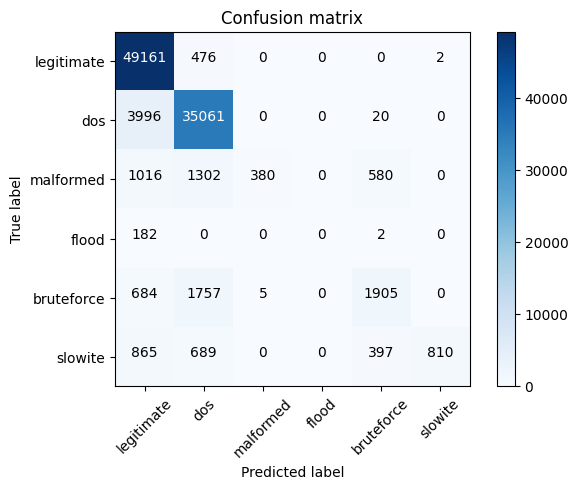

In [50]:
# # Evaluate 

# rf_prediction_train = rf_model.transform(df_train)
# rf_prediction_test = rf_model.transform(df_test)

# evaluator = MulticlassClassificationEvaluator(predictionCol='prediction',labelCol = 'label')

# rf_accuracy_train = evaluator.evaluate(rf_prediction_train)
# rf_accuracy_test = evaluator.evaluate(rf_prediction_test)

# print(f"Random Forest Train accuracy = {np.round(rf_accuracy_train*100,2)}%, test accuracy = {np.round(rf_accuracy_test*100,2)}%")

# # Plot confusion matrix

# outcome_pandas = rf_prediction_test.select("label").toPandas()
# rf_prediction_pandas = rf_prediction_test.select("prediction").toPandas()
# outcome_names_int = [0.0,1.0,2.0,3.0,4.0, 5.0]
# outcome_names = ["legitimate","dos","malformed","flood","bruteforce", "slowite"]

# cnf_matrix = confusion_matrix(outcome_pandas, rf_prediction_pandas,labels=outcome_names_int)
# #cnf_matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=outcome_names, title='Confusion matrix')
# plt.show()


The first ParamGrid we used has two params grid: rf.numTrees,[100, 200, 300], and rf.maxDepth,[10, 20, 30]. However, the test accuracy is 70%, which is significantly lower than the first model, which has a default number of trees of 20 and max depth of 5. By getting the params of best model, it is consisted of 100 trees and depth of 20. As a result, the drop of test accuracy is most likely to be attributed to overfitting. 
For the second run, the params grid was changed to [20, 30, 40, 50, 80] for number of trees and [10,15, 20] for maxDepth. The test accuracy goes up to 

In [80]:
# rf_param_grid = ParamGridBuilder().addGrid(rf.numTrees,[20, 30, 40, 50, 80]).addGrid(rf.maxDepth,[5, 10, 15]).build()
 
# rf_cv = CrossValidator(estimator=rf,estimatorParamMaps=rf_param_grid,evaluator=evaluator,numFolds=5)

# rf_cv_model = rf_cv.fit(df_train)
# rf_cv_prediction_test = lr_model.transform(df_train)
# rf_cv_accuracy_test = evaluator.evaluate(rf_cv_prediction_test)
# print(f"After tuning, Random Forest test accuracy = {np.round(rf_cv_accuracy_test*100,2)}%")



After tuning, Random Forest test accuracy = 79.31%


In [81]:
# print(rf_cv_model.getEstimatorParamMaps()[np.argmax(rf_cv_model.avgMetrics)])


{Param(parent='RandomForestClassifier_fa6bddc7c9db', name='numTrees', doc='Number of trees to train (>= 1).'): 80, Param(parent='RandomForestClassifier_fa6bddc7c9db', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 15}


In [72]:
# print(rf_cv_model.getEstimatorParamMaps()[np.argmax(rf_cv_model.avgMetrics)])


{Param(parent='RandomForestClassifier_fa6bddc7c9db', name='numTrees', doc='Number of trees to train (>= 1).'): 100, Param(parent='RandomForestClassifier_fa6bddc7c9db', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 15}


--------------PySpark ML Multi layer Perceptron----------------------

In [113]:
from pyspark.ml.classification import MultilayerPerceptronClassifier


In [137]:
layers = [30, 10, 20,  6]
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

nn_model = trainer.fit(df_train)

nn_prediction_train = nn_model.transform(df_train)
nn_prediction_test = nn_model.transform(df_test)

predictionAndLabels = nn_prediction_test.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))





Test set accuracy = 0.8107035096077497


In [170]:
layers1 = [30, 10, 20,  20, 6]
trainer1 = MultilayerPerceptronClassifier(maxIter=100, layers=layers1, blockSize=128, seed=1234)

nn_model1 = trainer1.fit(df_train)

nn_prediction_train1 = nn_model1.transform(df_train)
nn_prediction_test1 = nn_model1.transform(df_test)

predictionAndLabels1 = nn_prediction_test1.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels1)))



Test set accuracy = 0.7916336555221043


In [173]:
nn_param_grid = ParamGridBuilder().addGrid(trainer.layers,
                                           [[30, 10, 20,  6],
                                            [30, 10, 20, 20,  6],
                                            [30, 10, 20, 40, 6],
                                            [30, 10, 20, 40, 20, 6]]).build()
#  .addGrid(trainer.maxIter,[100])
nn_cv = CrossValidator(estimator=trainer,estimatorParamMaps=nn_param_grid,evaluator=evaluator,numFolds=5)


In [174]:
nn_cv_model = nn_cv.fit(df_train)

nn_cv_prediction_train = nn_cv_model.transform(df_train)
nn_cv_prediction_test = nn_cv_model.transform(df_test)

predictionAndLabels = nn_prediction_test.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))



22/11/27 17:38:26 WARN CacheManager: Asked to cache already cached data.
22/11/27 17:38:26 WARN CacheManager: Asked to cache already cached data.
22/11/27 17:39:46 WARN CacheManager: Asked to cache already cached data.
22/11/27 17:39:46 WARN CacheManager: Asked to cache already cached data.
Test set accuracy = 0.8107035096077497


---------------TF ---------------------------------------------------

In [143]:
from tensorflow import keras
import tensorflow as tf  # now import the tensorflow module
print(tf.__version__)  # make sure the version is 2.x
# from pyspark.sql.functions import udf
import pandas as pd
import numpy as np

2.10.0


In [144]:
df_validate, df_test = df_test.randomSplit([0.5,0.5])
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))


df_train_pandas = df_train.withColumn('features', to_array('features')).toPandas()
df_validate_pandas = df_validate.withColumn('features', to_array('features')).toPandas()
df_test_pandas = df_test.withColumn('features', to_array('features')).toPandas()

x_train = tf.constant(np.array(df_train_pandas['features'].values.tolist()))
y_train = tf.constant(np.array(df_train_pandas['label'].values.tolist()))

x_validate = tf.constant(np.array(df_validate_pandas['features'].values.tolist()))
y_validate = tf.constant(np.array(df_validate_pandas['label'].values.tolist()))


x_test = tf.constant(np.array(df_test_pandas['features'].values.tolist()))
y_test = tf.constant(np.array(df_test_pandas['label'].values.tolist()))

In [147]:
model.evaluate(x_test,y_test,verbose = 2)

198/198 - 1s - loss: 0.4237 - Accuracy_epochs: 0.8005 - 747ms/epoch - 4ms/step


[0.4236796498298645, 0.8005070090293884]

-----------------------TF shallow NN CV------------------------------

In [178]:
from sklearn.model_selection import KFold

num_folds = 5
HP_DEPTH_shallowNN_CV = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
log_dir_tfShallowNN_CV = "Desktop/" + "TFshallowNNCV"
Acc_shallow = []
Loss_shallow = []

In [179]:
from tensorboard.plugins.hparams import api as hp

HP_WIDTH_shallowNN = hp.HParam('NN_width', hp.Discrete([15, 25, 35, 50]))
HP_ActivationFunc_shallowNN = hp.HParam('activation_func', hp.Discrete(['tanh']))

with tf.summary.create_file_writer(log_dir_tfShallowNN_CV).as_default():
    hp.hparams_config(
        hparams=[HP_WIDTH_shallowNN, HP_ActivationFunc_shallowNN],
        metrics=[hp.Metric('Accuracy')],
    )

In [180]:
def train_test_model(hparams,logdir):
    model = keras.Sequential()
    
    for _ in range(HP_DEPTH_shallowNN_CV):
        model.add(keras.layers.Dense(hparams[HP_WIDTH_shallowNN] ,activation=hparams[HP_ActivationFunc_shallowNN]))
        
    model.add(keras.layers.Dense(6))
    
    model.compile(optimizer = 'adam',
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics = [keras.metrics.SparseCategoricalAccuracy(name = 'Accuracy_epochs')])

#     callback = [tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)]
    callback = tf.keras.callbacks.EarlyStopping(monitor="val_Accuracy_epochs", patience = 5, min_delta=0.0003, restore_best_weights=True)
#     By setting restore_best_weights=True in callback, the best model is used for prediction
    history_shallowNN_CV = model.fit(x_train, y_train, epochs=15, verbose = 2,
    callbacks=callback,
    validation_data = (x_validate, y_validate))
    
    results = model.evaluate(x_test, y_test, batch_size=128)
    
    accuracy = np.max(history_shallowNN_CV.history["val_Accuracy_epochs"])
    return accuracy, results

In [ ]:

for hp_activationfunc in HP_ActivationFunc_shallowNN.domain.values:
    for width in (HP_WIDTH_shallowNN.domain.values):
        hparams = {
            HP_WIDTH_shallowNN: width,
            HP_ActivationFunc_shallowNN: hp_activationfunc,
        }
        run_name = f"run-WIDTH{int(hparams[HP_WIDTH_shallowNN])}-ActivationFunction{hparams[HP_ActivationFunc_shallowNN]}"
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})

        run_dir = log_dir_tfShallowNN_CV + run_name
        accuracy, results = train_test_model(hparams,run_dir)
        print("***************************test loss, test acc:", results)

        with tf.summary.create_file_writer(run_dir).as_default():
            hp.hparams(hparams)  # record the values used in this trial
            tf.summary.scalar("Accuracy", accuracy, step=1)

--------------------TF Deep NN CV------------------------------------

In [188]:
from sklearn.model_selection import KFold

num_folds = 5
HP_DEPTH_DeepNN_CV = 25
kfold = KFold(n_splits=num_folds, shuffle=True)
log_dir_tfDeepNN_CV = "Desktop/" + "TFDeepNNCV"


In [189]:
from tensorboard.plugins.hparams import api as hp

HP_WIDTH_DeepNN = hp.HParam('NN_width', hp.Discrete([10, 15, 20]))
# HP_ActivationFunc_DeepNN = hp.HParam('activation_func', hp.Discrete(['sigmoid', 'tanh']))
HP_ActivationFunc_DeepNN = hp.HParam('activation_func', hp.Discrete(['tanh']))

with tf.summary.create_file_writer(log_dir_tfDeepNN_CV).as_default():
    hp.hparams_config(
        hparams=[HP_WIDTH_DeepNN, HP_ActivationFunc_DeepNN],
        metrics=[hp.Metric('Accuracy')],
    )
    
    

In [190]:
def train_test_model(hparams,logdir):
    model = keras.Sequential()
    
    for _ in range(HP_DEPTH_DeepNN_CV):
        model.add(keras.layers.Dense(hparams[HP_WIDTH_DeepNN] ,activation=hparams[HP_ActivationFunc_DeepNN]))
        
    model.add(keras.layers.Dense(6))
    
    model.compile(optimizer = 'adam',
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics = [keras.metrics.SparseCategoricalAccuracy(name = 'Accuracy_epochs')])

    #     callback = [tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)]
    callback = tf.keras.callbacks.EarlyStopping(monitor="val_Accuracy_epochs", patience = 5, min_delta=0.0003, restore_best_weights=True)
    history_DeepNN_CV = model.fit(x_train, y_train, epochs=15, verbose = 2,
    callbacks=callback,
    validation_data = (x_validate, y_validate))
    
    results = model.evaluate(x_test, y_test, batch_size=128)


    accuracy = np.max(history_DeepNN_CV.history["val_Accuracy_epochs"])
    return accuracy, results


In [ ]:

for hp_activationfunc in HP_ActivationFunc_DeepNN.domain.values:
    for width in (HP_WIDTH_DeepNN.domain.values):
        hparams = {
            HP_WIDTH_DeepNN: width,
            HP_ActivationFunc_DeepNN: hp_activationfunc,
        }
        run_name = f"run-WIDTH{int(hparams[HP_WIDTH_DeepNN])}-ActivationFunction{hparams[HP_ActivationFunc_DeepNN]}"
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})

        run_dir = log_dir_tfDeepNN_CV + run_name
        accuracy, results = train_test_model(hparams,run_dir)
        print("***************************test loss, test acc:", results)

        with tf.summary.create_file_writer(run_dir).as_default():
            hp.hparams(hparams)  # record the values used in this trial
            tf.summary.scalar("Accuracy", accuracy, step=1)